In [1]:
import numpy as np
from sklearn.preprocessing import normalize as sklearn_normalize
from scipy.sparse import isspmatrix, dok_matrix, csc_matrix
import networkx as nx
import plotly.graph_objects as go

import matplotlib.pyplot as plt
import logging
import time

#List of all librairies to import
import json
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
from tqdm import tqdm
import random
import pandas as pd


from concurrent.futures import ProcessPoolExecutor

from functools import partial
from multiprocessing import Pool


from wordcloud import WordCloud

import plotly.graph_objects as go

import heapq

import os
import pickle

from datetime import datetime

from collections import deque
from matplotlib.colors import to_hex

import seaborn as sns 
from networkx.algorithms.centrality import edge_betweenness_centrality
%matplotlib inline

Loading the graph

Nombre de nœuds : 1791489
Nombre d'arêtes : 25447873


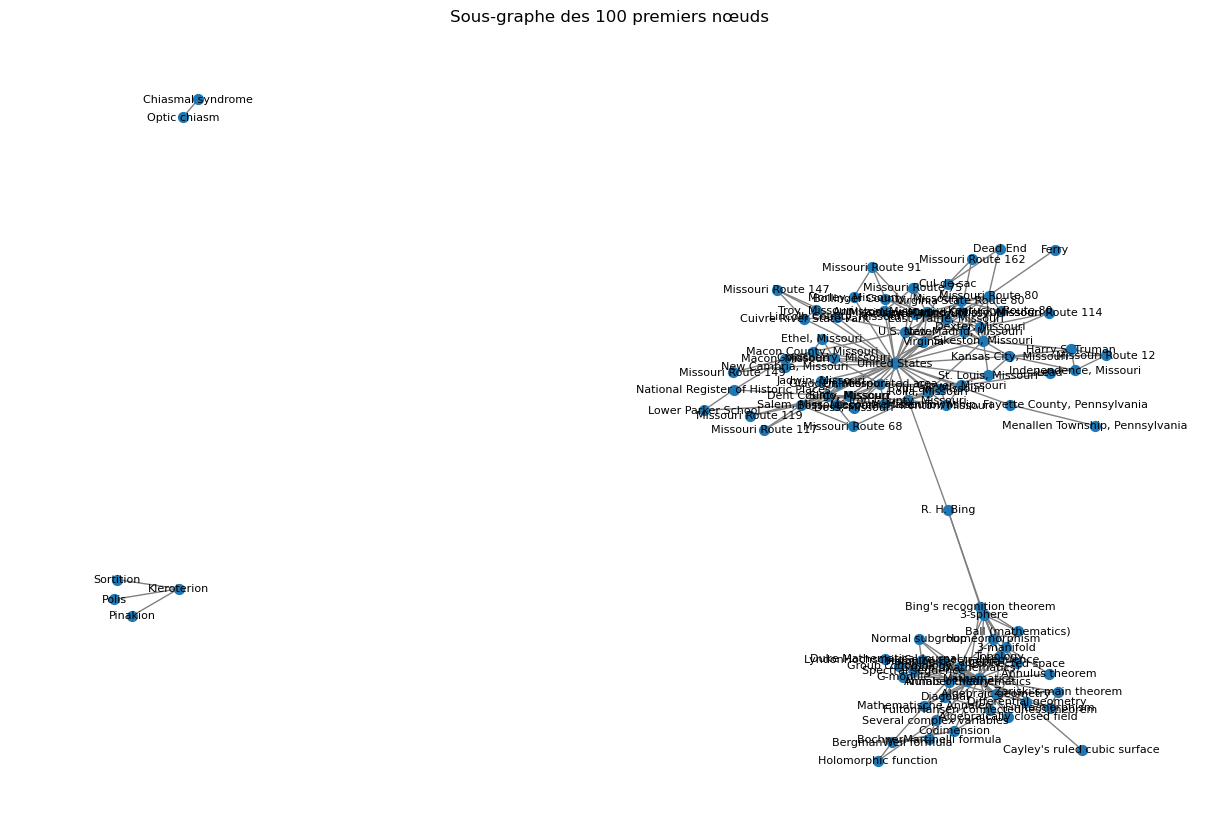

In [2]:
import gzip


# Charger les arêtes du graphe
def load_edges(file_path):
    edges = []
    with gzip.open(file_path, 'rt') as f:  # Ouvrir en mode texte
        for line in f:
            source, target = map(int, line.strip().split())
            edges.append((source, target))
    return edges

# Charger les noms des pages
def load_page_names(file_path):
    page_names = {}
    with gzip.open(file_path, 'rt') as f:  # Ouvrir en mode texte
        for line in f:
            line = line.strip()
            if not line:  # Ignorer les lignes vides
                continue
            parts = line.split(' ', 1)
            if len(parts) == 2:  # Vérifier que la ligne contient bien deux parties
                page_id, page_name = parts
                page_names[int(page_id)] = page_name
    return page_names

# Chemins vers les fichiers
base_path = "data/big_graph"
edges_file = f"{base_path}/wiki-topcats.txt.gz"
page_names_file = f"{base_path}/wiki-topcats-page-names.txt.gz"

# Charger les données
edges = load_edges(edges_file)
page_names = load_page_names(page_names_file)

# Créer le graphe
G = nx.Graph()
G.add_edges_from(edges)  # Ajouter les arêtes

# Ajouter les noms des pages comme attributs des nœuds
nx.set_node_attributes(G, page_names, "name")

# Informations sur le graphe
print(f"Nombre de nœuds : {G.number_of_nodes()}")
print(f"Nombre d'arêtes : {G.number_of_edges()}")

# Visualiser une sous-partie du graphe
subgraph = G.subgraph(list(G.nodes)[:100])  # Prenez un sous-graphe avec 100 nœuds
pos = nx.spring_layout(subgraph, seed=42)  # Layout pour la visualisation
plt.figure(figsize=(12, 8))
nx.draw(
    subgraph,
    pos,
    with_labels=True,
    labels={node: G.nodes[node]["name"] for node in subgraph.nodes},  # Utiliser les noms des pages
    node_size=50,
    font_size=8,
    edge_color="gray",
)
plt.title("Sous-graphe des 100 premiers nœuds")
plt.show()

In [3]:
# Visualiser une sous-partie du graphe
subgraph = G.subgraph(list(G.nodes)[:1000])  # Prenez un sous-graphe avec 100 nœuds

In [4]:
import networkx as nx
import numpy as np

# enumerate the nodes in the graph
subgraph_node_list = list(subgraph.nodes())
print(f"Number of nodes: {len(subgraph_node_list)}")
print(f"Node List: {subgraph_node_list}")

# number of edges in the subgraph
print(f"Number of edges: {subgraph.number_of_edges()}")


# Convert the graph to a dense adjacency matrix
adj_matrix = nx.adjacency_matrix(subgraph).toarray()

# Save the adjacency matrix to a file (optional)
np.save("adj_matrix.npy", adj_matrix)

# Print the shape of the adjacency matrix
print(f"Adjacency Matrix Shape: {adj_matrix.shape}")

with open("subgraph_edge_list.txt", 'w') as f:
        for edge in subgraph.edges():
            f.write(f"{edge[0]} {edge[1]} 1.0\n")

Number of nodes: 1000
Node List: [0, 1, 2, 3, 1101827, 1101828, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 23, 24, 20, 26, 22, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 1069112, 54, 55, 56, 278588, 57, 58, 59, 60, 61, 62, 63, 64, 65, 1101894, 66, 67, 68, 69, 70, 1189964, 327757, 71, 72, 73, 81, 82, 280657, 84, 290900, 77, 78, 79, 292953, 83, 85, 1181788, 86, 87, 88, 89, 90, 91, 1214563, 1101924, 92, 93, 94, 1777768, 96, 1056874, 98, 1409132, 100, 101, 102, 239728, 107, 105, 106, 109, 57461, 110, 111, 113, 1101945, 114, 115, 116, 117, 1169534, 118, 119, 120, 121, 122, 123, 124, 1486982, 612486, 1489032, 1177736, 694410, 1577098, 1489035, 639118, 1489040, 1177745, 1538194, 239763, 639126, 340125, 1218719, 745632, 1172760, 1101987, 250020, 1106090, 1777843, 65572, 205, 170193, 155862, 1296606, 280799, 194783, 8418, 1544420, 2277, 1179882, 1013995, 485611, 2288, 155888, 1179890, 1165558, 67832, 790783,

Helper functions

In [5]:
def normalize(M):
    return sklearn_normalize(M, norm="l1", axis=0)

In [6]:
def get_clusters(matrix):
    """
    Retrieve the clusters from the matrix
    
    :param matrix: The matrix produced by the MCL algorithm
    :returns: A list of tuples where each tuple represents a cluster and
              contains the indices of the nodes belonging to the cluster
    """

    if not isspmatrix(matrix):
        # Convert dense matrix to sparse to use sparse-specific methods
        matrix = csc_matrix(matrix)


    # get the attractors - non-zero elements of the matrix diagonal
    attractors = matrix.diagonal().nonzero()[0]
    print("Attractors:", attractors)

    # somewhere to put the clusters
    clusters = set()

    # the nodes in the same row as each attractor form a cluster
    for attractor in attractors:
        cluster = tuple(matrix.getrow(attractor).nonzero()[1].tolist())
        clusters.add(cluster)

    return sorted(list(clusters))

Main algorithm

In [18]:
def mcl(M, inflation, max_iter=10, epsilon=1e-4, verbose=0):
    """
    Perform Markov Clustering (MCL) on a graph represented by an edge list file.

    Args:
        file_path (str): Path to the file containing the edge list.
        inflation (float): Inflation parameter for the MCL algorithm.
        max_iter (int): Maximum number of iterations to perform.
        epsilon (float): Convergence threshold for the Frobenius norm.

    Returns:
        numpy.ndarray: The final matrix after MCL processing.
    """
    print("Starting MCL algorithm")
    # Convert to adjacency matrix
    # M, _ = edge_list_to_adjacency_matrix(file_path)

    # Into numpy
    M = np.array(M, dtype=float)
    # Initialization
    M = normalize(M)

    convergence = False
    previous_M = M
    i = 0
    total_time = 0  # To keep track of total time across all iterations
    iteration_times = []

    while i < max_iter and not convergence:
        print(f"Iteration {i + 1} started") if verbose >= 1 else None
        iteration_start_time = time.time()

        # Expansion
        expansion_start_time = time.time()
        M = np.matmul(M, M)
        expansion_time = time.time() - expansion_start_time
        print(f"Expansion took {expansion_time} seconds") if verbose == 2 else None

        # Inflation
        inflation_start_time = time.time()
        M = np.power(M, inflation)
        M = normalize(M)
        inflation_time = time.time() - inflation_start_time
        print(f"Inflation took {inflation_time} seconds") if verbose >= 2 else None

        # Check convergence using Frobenius norm
        diff_norm = np.linalg.norm(previous_M - M)
        print(f"Frobenius norm difference = {diff_norm}") if verbose >= 1 else None

        convergence = diff_norm < epsilon
        if convergence:
            print(f"Convergence achieved at iteration {i + 1}")

        previous_M = M
        iteration_end_time = time.time()
        iteration_time = iteration_end_time - iteration_start_time
        total_time += iteration_time
        print(f"Iteration {i + 1}: Total iteration time = {iteration_time} seconds") if verbose >= 1 else None
        iteration_times.append(iteration_time)

        i += 1

    # Log total time
    print("Total time for MCL processing: %.6f seconds", total_time) if verbose >= 1 else None

    # Log final matrix
    print("Final matrix:\n%s", M) if verbose >= 2 else None

    return M, iteration_times

Runnning the algorithm

In [19]:
# running the algo with differen inflation values
inflation_values = [1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]

my_final_matrices = {}
for inflation in inflation_values:
    print("Running MCL with inflation = %.2f", inflation)
    final_matrix, _ = mcl(adj_matrix, inflation=inflation, max_iter=200, epsilon=1e-7, verbose=2)
    my_final_matrices[inflation] = final_matrix

Running MCL with inflation = %.2f 1.1
Starting MCL algorithm
Iteration 1 started
Expansion took 0.1838207244873047 seconds
Inflation took 0.01755499839782715 seconds
Frobenius norm difference = 15.986473149457462
Iteration 1: Total iteration time = 0.2037339210510254 seconds
Iteration 2 started
Expansion took 0.018977880477905273 seconds
Inflation took 0.03453493118286133 seconds
Frobenius norm difference = 3.7254728427320165
Iteration 2: Total iteration time = 0.05621504783630371 seconds
Iteration 3 started
Expansion took 0.03841519355773926 seconds
Inflation took 0.030038118362426758 seconds
Frobenius norm difference = 2.5758473779697884
Iteration 3: Total iteration time = 0.07097911834716797 seconds
Iteration 4 started
Expansion took 0.03739023208618164 seconds
Inflation took 0.020655155181884766 seconds
Frobenius norm difference = 1.8969539532112143
Iteration 4: Total iteration time = 0.06066632270812988 seconds
Iteration 5 started
Expansion took 0.026067018508911133 seconds
Inflat

Extracting the clusters

In [38]:
# Extract clusters for each inflation value
clusters = {}
for inflation, matrix in my_final_matrices.items():
    print("Extracting clusters for inflation =", inflation)
    clusters[inflation] = get_clusters(matrix)

Extracting clusters for inflation = 1.1
Attractors: [  0  48 280 300 302 303 304]
Extracting clusters for inflation = 1.2
Attractors: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 21

In [39]:
# Save the clusters to files
for inflation, cluster_ids in clusters.items():
    with open(f"clusters_inf_{inflation}.txt", "w") as f:
        for cluster in cluster_ids:
            f.write(" ".join(map(str, cluster)) + "\n")

Modularity

In [40]:
def global_modularity(clusters, G):
    m = G.number_of_edges()  #Total number of edges in the graph

    #Transform the list of sets from 0...999 into actual node ids
    clusters = [{subgraph_node_list[node] for node in node_set} for node_set in clusters]
    
    #Modularity initialized to 0
    Q = 0

    #Iterate over each cluster
    for cluster in clusters:

        cluster_nodes = list(cluster) #convert the set to a list

        #Subgraph containing only the nodes and edges of the cluster
        subgraph = G.subgraph(cluster_nodes)

        #Number of edges inside the cluster
        L_c = subgraph.number_of_edges()

        #Sum of the degrees of the nodes in the cluster (all the edges that are connected to the nodes in the cluster)
        k_c = sum(G.degree(n) for n in cluster_nodes)

        #Add the modularity for the cluster
        Q += (L_c / m) - (k_c / (2 * m)) ** 2

    #Return the global modularity
    return Q



In [47]:
modularity = []

for inflation, cluster_list in clusters.items():
    modularity_value = global_modularity(cluster_list, subgraph)
    modularity.append((inflation, modularity_value, len(cluster_list)))

# Print the modularity values
for inflation, mod_value, cluster_size in modularity:
    print(f"Inflation: {inflation}, Modularity: {mod_value}, Number of clusters: {cluster_size}")

Inflation: 1.1, Modularity: 0.00021600602547791105, Number of clusters: 3
Inflation: 1.2, Modularity: 0.00021600602547791105, Number of clusters: 3
Inflation: 1.3, Modularity: 0.06857514320408123, Number of clusters: 8
Inflation: 1.4, Modularity: 0.08257000154633522, Number of clusters: 11
Inflation: 1.5, Modularity: 0.25996611135555325, Number of clusters: 21
Inflation: 1.6, Modularity: 0.2482154349273036, Number of clusters: 29
Inflation: 1.7, Modularity: 0.2441235529253749, Number of clusters: 37
Inflation: 1.8, Modularity: 0.25114909462824075, Number of clusters: 54
Inflation: 1.9, Modularity: 0.2378177433927788, Number of clusters: 73
Inflation: 2.0, Modularity: 0.2312409633705325, Number of clusters: 86


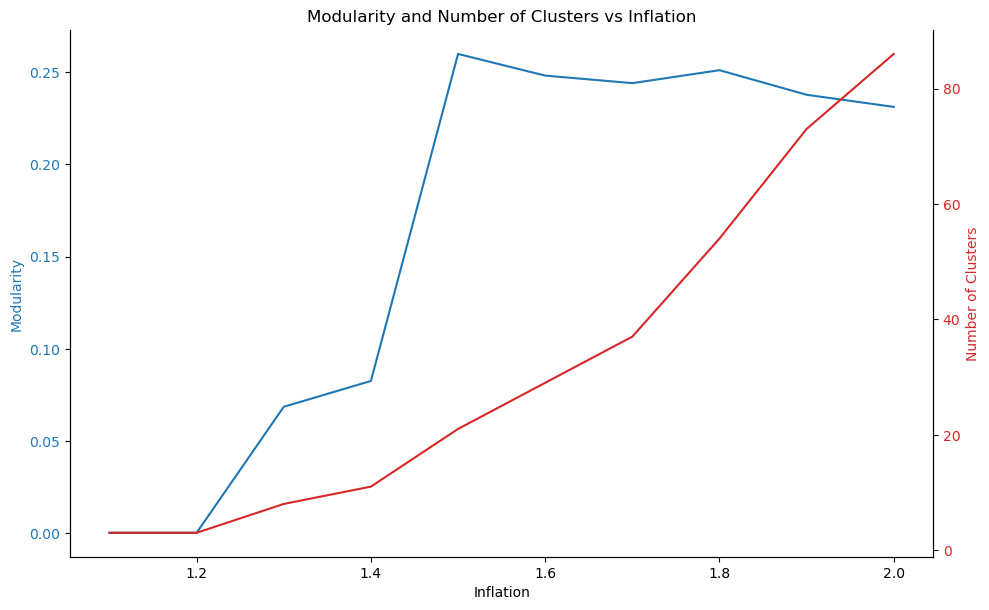

In [48]:
import seaborn as sns

# Unpack the modularity list into separate lists for plotting
inflation_values, modularity_values, cluster_counts = zip(*modularity)

fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Inflation')
ax1.set_ylabel('Modularity', color=color)
ax1.plot(inflation_values, modularity_values, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('Number of Clusters', color=color)  # we already handled the x-label with ax1
ax2.plot(inflation_values, cluster_counts, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title("Modularity and Number of Clusters vs Inflation")
sns.despine(fig=fig, right=False, left=False)
plt.savefig(
    "Modularity_and_Number_of_Clusters_vs_Inflation.pdf",  # Nom du fichier
    format="pdf",             # Format PDF
    dpi=300,                  # Résolution haute (300 DPI standard)
    bbox_inches="tight",      # Ajuste les marges autour de la figure
    pad_inches=0.05           # Réduit l'espace ajouté autour de la figure
)
plt.show()

Notice that we have the highest modularity when inflation is set to 1.5.

Vizualizing the clustering of the graph

In [58]:
def visualize_clusters_plotly(graph, clusters, node_list, title="Plotly-visualisation"):
    #We use plotly now to get interactive graphs 
    pos = nx.spring_layout(graph, seed=42)  # We want to generate a disposition of the nodes that is always the same
    print(len(pos))
    print(pos.keys())
    edge_x = []
    edge_y = []

    #Draw the edges
    for edge in graph.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])
    
    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color="#888"),
        hoverinfo="none",
        mode="lines"
    )

    #Draw nodes
    node_traces = []
    colors = plt.cm.get_cmap("hsv", len(clusters))
    #colors = plt.cm.get_cmap("tab20", len(clusters))
    
    #Draw the nodes, colored the same for each cluster
    for i, cluster in enumerate(clusters):
        print(f"Cluster {i + 1} has {len(cluster)} nodes")
        node_x = []
        node_y = []
        for node in cluster:
            x, y = pos[subgraph_node_list[node]]
            # x, y = pos[node]
            node_x.append(x)
            node_y.append(y)
        
        node_trace = go.Scatter(
            x=node_x, y=node_y,
            mode="markers",
            marker=dict(
                size=10,
                color=f"rgba({int(colors(i)[0]*255)}, {int(colors(i)[1]*255)}, {int(colors(i)[2]*255)}, 0.8)",
                line_width=2
            ),
            name=f"Cluster {i + 1}"
        )
        node_traces.append(node_trace)
    
    #Create figure
    fig = go.Figure(data=[edge_trace] + node_traces,
                    layout=go.Layout(
                        title=title,
                        titlefont_size=16,
                        showlegend=True,
                        hovermode="closest",
                        margin=dict(b=0, l=0, r=0, t=40),
                        xaxis=dict(showgrid=False, zeroline=False),
                        yaxis=dict(showgrid=False, zeroline=False)
                    ))
    fig.show(renderer="browser")



In [59]:
# Visualize the clusters using Plotly
visualize_clusters_plotly(subgraph, clusters[1.5], subgraph_node_list, title="MCL Clusters")

1000
dict_keys([0, 1, 2, 3, 1101827, 1101828, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 23, 24, 20, 26, 22, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 1069112, 54, 55, 56, 278588, 57, 58, 59, 60, 61, 62, 63, 64, 65, 1101894, 66, 67, 68, 69, 70, 1189964, 327757, 71, 72, 73, 81, 82, 280657, 84, 290900, 77, 78, 79, 292953, 83, 85, 1181788, 86, 87, 88, 89, 90, 91, 1214563, 1101924, 92, 93, 94, 1777768, 96, 1056874, 98, 1409132, 100, 101, 102, 239728, 107, 105, 106, 109, 57461, 110, 111, 113, 1101945, 114, 115, 116, 117, 1169534, 118, 119, 120, 121, 122, 123, 124, 1486982, 612486, 1489032, 1177736, 694410, 1577098, 1489035, 639118, 1489040, 1177745, 1538194, 239763, 639126, 340125, 1218719, 745632, 1172760, 1101987, 250020, 1106090, 1777843, 65572, 205, 170193, 155862, 1296606, 280799, 194783, 8418, 1544420, 2277, 1179882, 1013995, 485611, 2288, 155888, 1179890, 1165558, 67832, 790783, 471303, 155919, 2

/var/folders/k7/fy1xk_bx2k954dxyll0sm2_40000gp/T/ipykernel_53068/2429643528.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("hsv", len(clusters))


Cluster 1 has 1 nodes
Cluster 2 has 1 nodes
Cluster 3 has 589 nodes
Cluster 4 has 34 nodes
Cluster 5 has 297 nodes
Cluster 6 has 1 nodes
Cluster 7 has 1 nodes
Cluster 8 has 1 nodes
Cluster 9 has 5 nodes
Cluster 10 has 14 nodes
Cluster 11 has 1 nodes
Cluster 12 has 5 nodes
Cluster 13 has 44 nodes
Cluster 14 has 1 nodes
Cluster 15 has 1 nodes
Cluster 16 has 1 nodes
Cluster 17 has 3 nodes
Cluster 18 has 2 nodes
Cluster 19 has 2 nodes
Cluster 20 has 1 nodes
Cluster 21 has 1 nodes
